This code makes the leave-one-out classifiers for aspiration vs. non-aspiration based on:

- full communities
    - bal, throat, gastric only
    - two and three communities
- exchanged otus
    - presence of exchanged (i.e. concordance)
    - abundance of exchanged

In [34]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, auc, roc_curve


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util

# Read data

In [4]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

# Define some global variables
nml = 'Normal'
asp = 'Aspiration/Penetration'
mbs_col = 'mbs_consolidated'
aspdict = {'Normal': 0, 'Aspiration/Penetration': 1}
sites = util.get_sites()

## Prepare the data for easy manipulations
# This creates a 3-column df with ['sample', 'otu', 'abun']
meta = meta.dropna(subset=[mbs_col])
tidydf = util.tidyfy_otu(df, meta, mbs_col)

Tidying data... 
Finished.


In [5]:
tidydf.head()

,sample,otu,abun,mbs_consolidated,site,subject_id,otu_w_site
28,02-096-6G,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.0,Normal,gastric_fluid,02-096-6,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...
483,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
938,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1393,02-096-6G,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0,Normal,gastric_fluid,02-096-6,k__Bacteria;p__Actinobacteria;c__Actinobacteri...
1848,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


## Single-site classifiers

Most of this code will be taken from make_classifiers.py

In [6]:
def make_combined_site_df(tidydf, sites, mbs_col):
    """
    Return a wide-form dataframe with data from all sites.

    Drops any rows with NaNs (i.e. subjects which are missing
    one of the sites). Also drops any subjects without mbs_col
    metadata.

    Parameters
    ----------
    tidydf : pandas DataFrame
        'subject_id', 'site', and 'otu_w_site' columns
    sites : list
        list of sites to keep
    """

    tmpotu = tidydf.query('site == @sites')\
            .dropna(subset=[mbs_col])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna(axis=0)

    # Keep only OTUs which are non-zero in these samples
    tmpotu = tmpotu.loc[:, tmpotu.sum() > 0]

    # Also return the samples used in this
    subjects = tmpotu.index.tolist()
    samples = tidydf\
        .query('subject_id == @subjects')\
        .query('site == @sites')\
        ['sample']\
        .unique().tolist()

    return tmpotu, samples


In [7]:
sites = ['bal']
# Make wide dataframe with the right samples and OTUs
df, samples = make_combined_site_df(tidydf, sites, mbs_col)
df.shape, len(samples)

((66, 928), 66)

In [8]:
df.head()

otu_w_site,k__;p__;c__;o__;f__;g__;s__;d__denovo120--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo259--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo563--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo707--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo793--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo828--bal,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo869--bal,...,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo543--bal,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo594--bal,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo691--bal,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo764--bal,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo768--bal,k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Treponema;s__;d__denovo898--bal,k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Mycoplasma;s__;d__denovo379--bal,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__;d__denovo1074--bal,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__;d__denovo35--bal,k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia;s__;d__denovo63--bal
subject_id,,,,,,,,,,,,,,,,,,,,,
02-098-5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
02-120-4,0.0,0.0,0.0,0.000000,0.000275,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
02-184-5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
02-186-0,0.0,0.0,0.0,0.001712,0.000047,0.0,0.0,0.0,0.000157,0.0,...,0.000267,0.000188,0.0,0.000188,0.000047,0.000047,0.0,0.0,0.000047,0.0
03-089-3,0.0,0.0,0.0,0.000000,0.000106,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


Now, the part of the code that should iterate over each subject (i.e. row), build a classifier, use that classifier to predict the label of that subject, and return [subject, probability_class_1, probability_class_1, predicated_label, true_label] for each subject.

In [17]:
subj = df.index.tolist()[0]
df.drop(subj, axis=0).shape

(65, 928)

In [43]:
subjects = df.index.tolist()

# Get one dataframe with the aspiration status
mbs_info = tidydf\
    .query('subject_id == @subjects')\
    [['subject_id', 'mbs_consolidated']]\
    .drop_duplicates()

# Convert to dictionary
mbs_info = dict(zip(mbs_info['subject_id'], mbs_info['mbs_consolidated']))

In [32]:
random_state = 12345

res = []
for subj in subjects:

    # Remove the subject from the training dataframe
    train_X = df.drop(subj, axis=0)

    # Code up labels as 0 or 1. 
    # aspdict contains {mbs_label: 0 or 1}; mbs_info is {subject: mbs_label}
    train_Y = [aspdict[mbs_info[i]] for i in train_X.index.tolist()]
    
    # Convert to numpy matrix
    train_X = train_X.values
    
    # Get test data (just that subject)
    test_X = df.loc[subj].values.reshape(1, -1)
    test_Y = aspdict[mbs_info[subj]]
    
    # Set up classifier
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)
    rf = rf.fit(train_X, train_Y)

    # Probability of being class 1
    proba = rf.predict_proba(test_X)[:, 1]

    # This just gives "if proba > 0.5, classify as 1"
    pred = rf.predict(test_X)

    res.append([subj, test_Y, pred[0], proba[0]])

These results just give one prediction and probability per sample, so we can make one confusion matrix and one ROC curve normally (i.e. no need to interpolate or divide by the total number of CV-folds, as in the old code).

In [39]:
resdf.head()

,subject_id,true_label,predicted_label,prob_class_1
0,02-098-5,0,0,0.351
1,02-120-4,0,0,0.370
2,02-184-5,1,1,0.575
3,02-186-0,1,1,0.606
4,03-089-3,1,1,0.572


In [40]:
# Convert all results to dataframe
resdf = pd.DataFrame(data=res, 
    columns=['subject_id', 'true_label', 'predicted_label', 'prob_class_1'])

# Build confusion matrix and ROC curve
confmat = confusion_matrix(resdf['true_label'], resdf['predicted_label'], labels=[0,1])
fpr, tpr, thresholds = roc_curve(resdf['true_label'], resdf['prob_class_1'])
roc_auc = auc(fpr, tpr)

In [41]:
print(roc_auc)

0.6294765840220387


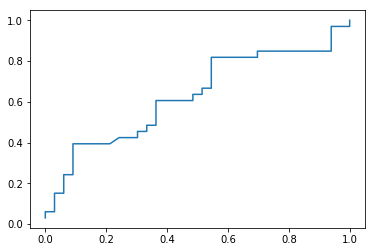

In [42]:
plt.plot(fpr, tpr)

Okay, this is super straightforward yay! Let's plug this back into the code for each type of classifier (hopefully it plays nicely with what I've already done...)